### Dmitrii Iakushechkin
#### Loss function: bce_dice_loss

The model was trained on Cloud GPUs on Google Colab. Some codes are borrowed from:
1. https://github.com/SaveraLLC/Indian-rooftops-detection
2. https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
3. https://towardsdatascience.com/image-segmentation-choosing-the-correct-metric-aa21fd5751af

---

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
imgs_dir = "images/"
masks_dir = "labels/"

#broken label
!rm 'images/278.png'
!rm 'labels/278.png'

#folder for predictions
!mkdir predictions

In [4]:
imgs_paths = sorted(os.listdir(imgs_dir))
mask_paths = sorted(os.listdir(masks_dir))
test_paths = imgs_paths[-5:]

print("\nTotal {} image paths found!".format(len(imgs_paths)))
print("Total {} mask paths found!\n".format(len(mask_paths)))

# Make pair of image and its masks
img_mask_paths_pair = {}
image_counter = 0

for imgpath, maskpath in zip(imgs_paths, mask_paths):
    if (imgpath == maskpath):
        imgfullpath = os.path.join(imgs_dir, imgpath)
        maskfullpath = os.path.join(masks_dir, maskpath)
        img_mask_paths_pair[imgfullpath] = maskfullpath

print("Total {} image-mask pairs".format(len(img_mask_paths_pair)))


Total 29 image paths found!
Total 24 mask paths found!

Total 24 image-mask pairs


#### Image processing (image to array, sharpening, normalization)

In [5]:
def load_data(paths_dict, outshape=(256, 256)):

    img_batch = []
    mask_batch = []
    # kernel from https://en.wikipedia.org/wiki/Kernel_(image_processing)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    for imgpath in paths_dict.keys():
        # Image
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.filter2D(img, -1, kernel) # image sharpening
        img = cv2.bilateralFilter(img, 3, 75, 75)
        img = cv2.resize(img, outshape) / 255 # normalize image
        # Mask
        mask = cv2.imread(paths_dict[imgpath], 0)
        mask = cv2.resize(mask, outshape)
        mask = np.expand_dims(mask, -1) / 255 # normalize image
            
        img_batch.append(img[np.newaxis, ...])
        mask_batch.append(mask[np.newaxis, ...])
    return np.concatenate(img_batch, axis=0), np.concatenate(mask_batch, axis=0)


X_train - array that contains images and masks

In [6]:
X_train = load_data(dict(list(img_mask_paths_pair.items())))

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [127]:
# PARAMETERS
BATCHSIZE = 16
MODEL_INPUT_SHAPE = (256, 256)
seed = 42

#### Data augmentation

In [128]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

def get_train_test_augmented(X_data=X_train[0], Y_data=X_train[1], validation_split=0.15, batch_size=BATCHSIZE, seed=seed):
    X_train, X_val, Y_train, Y_val = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    print("Train images:", X_train.shape)
    print("Validation images:", X_val.shape)
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True)


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Val data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_val, augment=True, seed=seed)
    Y_datagen_val.fit(Y_val, augment=True, seed=seed)
    X_val_augmented = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
    Y_val_augmented = Y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    val_generator = zip(X_val_augmented, Y_val_augmented)
    
    return train_generator, val_generator

In [38]:
train_generator, val_generator = get_train_test_augmented(X_data=X_train[0], Y_data=X_train[1], validation_split=0.15, batch_size=BATCHSIZE)

Train images: (20, 256, 256, 3)
Validation images: (4, 256, 256, 3)


#### One batch of images with data augmentation 

Batch: (2, 256, 256, 3) (2, 256, 256, 1)


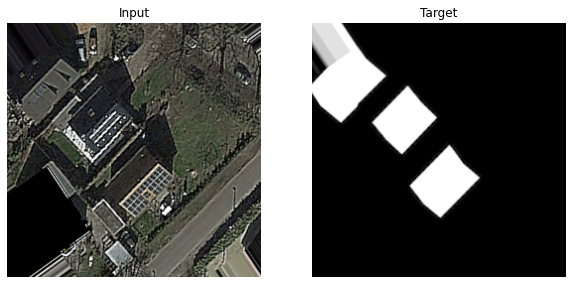

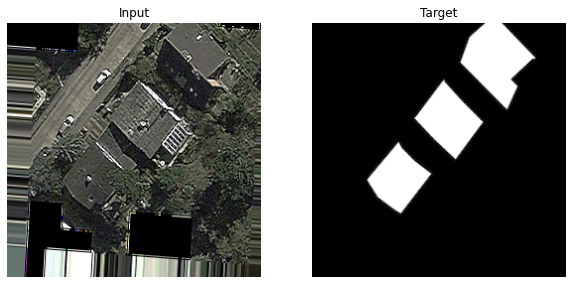

In [40]:
counter = 0
for k in train_generator:
    counter +=1
    imgs, masks = k
    print("Batch:", imgs.shape, masks.shape)
    for i, (img, mask) in enumerate(zip(imgs, masks)):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title('Input')
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title('Target')
        plt.imshow(mask.reshape(MODEL_INPUT_SHAPE), cmap='gray')

        plt.show()
    # if counter > 0:
    break

The U-Net architecture is from https://github.com/SaveraLLC/Indian-rooftops-detection

In [11]:
!git clone https://github.com/SaveraLLC/Indian-rooftops-detection.git

Cloning into 'Indian-rooftops-detection'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.


In [129]:
import sys
sys.path.insert(0, './Indian-rooftops-detection/')
from u_net import get_unet_256
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

#load architecture
model = get_unet_256()
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
# model.summary()

#### Callbacks 

In [116]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
model_name = 'task'
save_dir = '{}_chkpt'.format(model_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
weight_path="{}/{}_weights.best.hdf5".format(save_dir, model_name)
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True
                            )
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.2,
                                   patience=1, 
                                   verbose=1, 
                                   mode='min',
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=1e-8
                                  )
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20
                     )

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [132]:
# LOAD CHECKPOINT (IF ANY)
try:
    model.load_weights(weight_path)
    print("CheckPoint loaded!")
except:
    print("No CheckPoint found.")
    pass

CheckPoint loaded!


In [130]:
# START TRAINING
train_generator, val_generator = get_train_test_augmented(X_data=X_train[0], Y_data=X_train[1], validation_split=0.2, batch_size=BATCHSIZE)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train[0]),
    validation_data=val_generator,
    validation_steps=len(X_train[1]),
    epochs=250,    # I knew that it would be too much, but thanks to the callbacks I can keep the best weights
    callbacks=callbacks_list
)

Train images: (19, 256, 256, 3)
Validation images: (5, 256, 256, 3)
Epoch 1/250
24/24 [==============================] - ETA: 0s - loss: 0.9081 - dice_loss: 0.5387
Epoch 00001: val_loss did not improve from 0.96744
24/24 [==============================] - 16s 662ms/step - loss: 0.9081 - dice_loss: 0.5387 - val_loss: 1046.5824 - val_dice_loss: 0.7647
Epoch 2/250
24/24 [==============================] - ETA: 0s - loss: 0.5505 - dice_loss: 0.3615
Epoch 00002: val_loss did not improve from 0.96744
24/24 [==============================] - 15s 616ms/step - loss: 0.5505 - dice_loss: 0.3615 - val_loss: 195.9272 - val_dice_loss: 0.7645
Epoch 3/250
24/24 [==============================] - ETA: 0s - loss: 0.4544 - dice_loss: 0.2992
Epoch 00003: val_loss did not improve from 0.96744
24/24 [==============================] - 15s 621ms/step - loss: 0.4544 - dice_loss: 0.2992 - val_loss: 27.6002 - val_dice_loss: 0.7602
Epoch 4/250
24/24 [==============================] - ETA: 0s - loss: 0.3730 - dice_

KeyboardInterrupt: ignored

### Evaluation

In [1]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(26)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Training image 

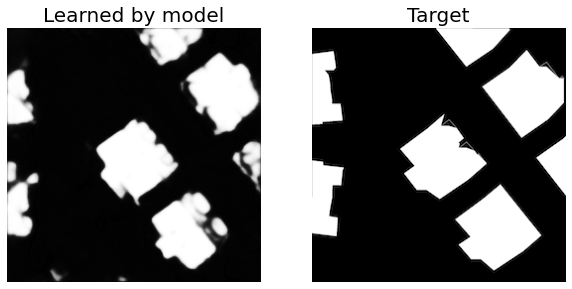

In [137]:
img_no = 2
imgs, masks = X_train
testimg = imgs[img_no].reshape(1, 256, 256, 3)
targetmask = masks[img_no].reshape(MODEL_INPUT_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Learned by model', fontsize=20)
plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()

#### Load test images

In [138]:
test_paths_full = dict()
for path in test_paths:
    test_paths_full[os.path.join(imgs_dir, path)] = os.path.join(imgs_dir, path)

X_test = load_data(dict(list(test_paths_full.items())))

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


### Predict the roof locations (test) 

Batch: (5, 256, 256, 3) (5, 256, 256, 1)


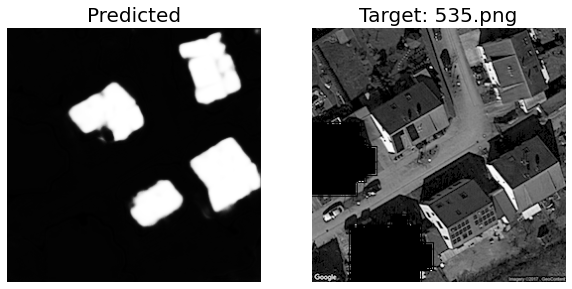

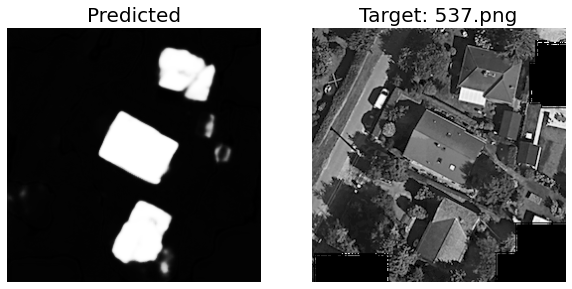

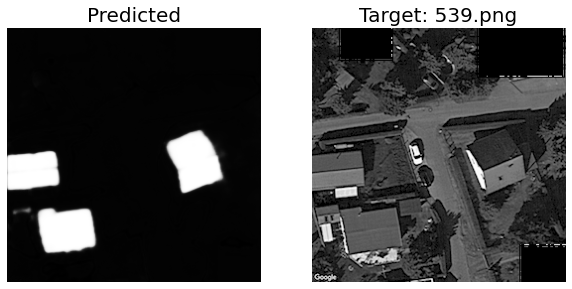

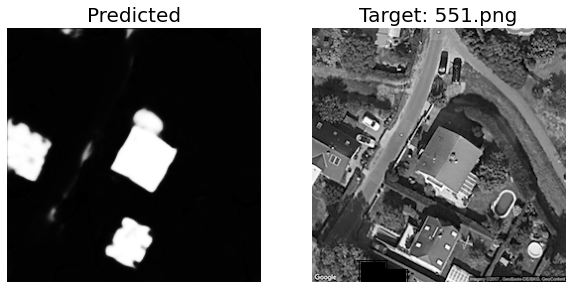

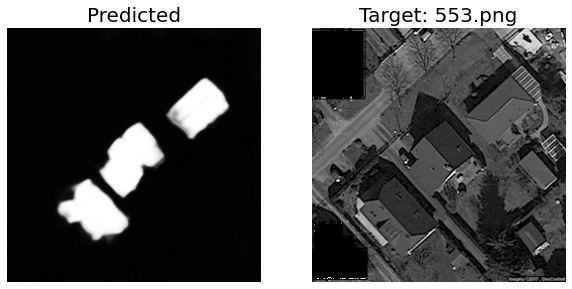

In [139]:
from PIL import Image

imgs, masks = X_test
print("Batch:", imgs.shape, masks.shape)
test_names = iter(test_paths)
for img, mask in zip(imgs, masks):
    name = next(test_names)
    testimg = img.reshape(1, 256, 256, 3)
    targetmask = mask.reshape(MODEL_INPUT_SHAPE)
    pred = model.predict(testimg)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Predicted', fontsize=20)
    plt.imshow(pred.reshape(MODEL_INPUT_SHAPE), cmap='gray')
    res = Image.fromarray((pred.reshape(MODEL_INPUT_SHAPE)* 255).astype(np.uint8))
    res.save('predictions/{}'.format(name))
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Target: {}'.format(name), fontsize=20)
    plt.imshow(targetmask, cmap='gray')
    plt.show()

#### Save results

In [140]:
from google.colab import files

!zip -r /content/predictions.zip /content/predictions -q

files.download('predictions.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>